In [1]:
!pip install git+https://github.com/d2l-ai/d2l-en

  Cloning https://github.com/d2l-ai/d2l-en to /tmp/pip-req-build-b08bpspk
  Running command git clone -q https://github.com/d2l-ai/d2l-en /tmp/pip-req-build-b08bpspk
  Created wheel for d2l: filename=d2l-0.16.2-cp37-none-any.whl size=77221 sha256=0c2c6ba8814d1cdc96a8dc2754a21d8d568670c91f4bfd66f7245e894109040c
  Stored in directory: /tmp/pip-ephem-wheel-cache-udu0pmc5/wheels/82/6f/b8/8422c7ed664272685e3d139b127f89df39d934704a14b2156c
Successfully built d2l


In [2]:
%matplotlib inline
from d2l import tensorflow as d2l
import tensorflow as tf

In [3]:
tf.__version__

'2.4.1'

In [4]:
X = d2l.normal([1000, 2], 0.0, 1, tf.float32)
A = d2l.tensor([[1, 2], [-0.1, 0.5]], tf.float32)
b = d2l.tensor([1, 2], tf.float32)
data = d2l.matmul(X, A) + b

In [5]:
X

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[ 0.03979763,  0.21658216],
       [-0.00846096, -1.5548749 ],
       [-0.741201  ,  0.10753934],
       ...,
       [-0.9093773 ,  1.1343874 ],
       [-0.32907954, -0.6627376 ],
       [ 1.1279589 ,  0.9322923 ]], dtype=float32)>

The covariance matrix is
[[1.01 1.95]
 [1.95 4.25]]


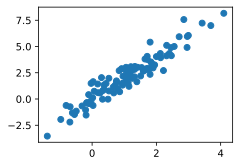

In [6]:
d2l.set_figsize()
d2l.plt.scatter(d2l.numpy(data[:100, 0]), d2l.numpy(data[:100, 1]));
print(f'The covariance matrix is\n{d2l.matmul(tf.transpose(A), A)}')

In [7]:
batch_size = 8
data_iter = d2l.load_array((data,), batch_size)

In [8]:
net_G = tf.keras.Sequential()
net_G.add(tf.keras.layers.Dense(2))

In [9]:
net_D = tf.keras.Sequential()
net_D.add(tf.keras.layers.Dense(5, activation='tanh'))
net_D.add(tf.keras.layers.Dense(3, activation='tanh'))
net_D.add(tf.keras.layers.Dense(1))

https://codingnote.cc/p/289284/

In [10]:
batch_size = X.shape[0]


In [11]:
print(batch_size)

1000


In [12]:
ones = tf.ones_like(batch_size)

In [13]:
print(ones)

tf.Tensor(1, shape=(), dtype=int32)


In [14]:
#@save
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = tf.ones_like(batch_size, tf.float32)# , device=X.device)
    zeros = tf.zeros_like(batch_size, tf.float32)# , device=X.device)
    with tf.GradientTape() as D_tape:
        real_Y = net_D(X, training=True)
        fake_X = net_G(X, training=True)
        # Do not need to compute gradient for `net_G`, detach it from
        # computing gradients.
        fake_Y = net_D(tf.stop_gradient(fake_X), training=False)
        loss_D = (loss(ones, real_Y) + loss(zeros, fake_Y)) / 2
    grads = D_tape.gradient(loss_D, net_D.trainable_variables)
    trainer_D.apply_gradients(zip(grads, net_D.trainable_weights))
    return float(loss_D)

In [15]:
#@save
def update_G(Z, net_D, net_G, loss, trainer_G):
    """Update generator."""
    batch_size = Z.shape[0]
    ones = tf.ones_like(batch_size, tf.float32)
    with tf.GradientTape() as G_tape:
        # We could reuse `fake_X` from `update_D` to save computation
        fake_X = net_G(Z, training=True)
        # Recomputing `fake_Y` is needed since `net_D` is changed
        fake_Y = net_D(fake_X, training=True)
        loss_G = loss(ones, fake_Y)
    grads = G_tape.gradient(loss_G, net_G.trainable_variables) 
    trainer_G.apply_gradients(zip(grads, net_G.trainable_weights))
    return float(loss_G)

from_logits=True
https://github.com/thisisiron/TF2-GAN/blob/master/gan/train.py

tf.nn.sigmoid_cross_entropy_with_logits https://www.tensorflow.org/tutorials/generative/cvae

In [16]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = tf.keras.losses.BinaryCrossentropy(reduction=
                tf.keras.losses.Reduction.SUM)
    tf.keras.initializers.RandomNormal(net_D, stddev=0.02)
    tf.keras.initializers.RandomNormal(net_G, stddev=0.02)
    trainer_D = tf.keras.optimizers.Adam(learning_rate=lr_D)
    trainer_G = tf.keras.optimizers.Adam(learning_rate=lr_G)
    net_D.compile(optimizer=trainer_D)
    net_G.compile(optimizer=trainer_G)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(num_epochs):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for (X,) in data_iter:
            batch_size = X.shape[0]
            Z = d2l.normal([batch_size, latent_dim], 0, 1, tf.float32)
            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),
                       update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Visualize generated examples
        Z = d2l.normal([100, latent_dim], 0, 1, tf.float32)
        fake_X = net_G(tf.stop_gradient(Z), training=False).numpy()
        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(['real', 'generated'])
        # Show the losses
        loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
        animator.add(epoch + 1, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec')

loss_D 0.230, loss_G 1.532, 269.3 examples/sec


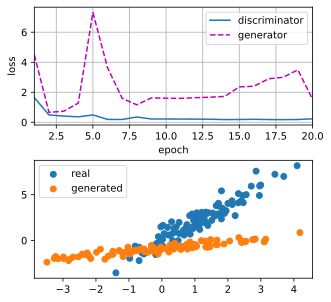

In [17]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G,
      latent_dim, d2l.numpy(data[:100]))

In [18]:
X

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[ 0.03979763,  0.21658216],
       [-0.00846096, -1.5548749 ],
       [-0.741201  ,  0.10753934],
       ...,
       [-0.9093773 ,  1.1343874 ],
       [-0.32907954, -0.6627376 ],
       [ 1.1279589 ,  0.9322923 ]], dtype=float32)>

In [19]:
X.shape

TensorShape([1000, 2])

In [20]:
X

<tf.Tensor: shape=(1000, 2), dtype=float32, numpy=
array([[ 0.03979763,  0.21658216],
       [-0.00846096, -1.5548749 ],
       [-0.741201  ,  0.10753934],
       ...,
       [-0.9093773 ,  1.1343874 ],
       [-0.32907954, -0.6627376 ],
       [ 1.1279589 ,  0.9322923 ]], dtype=float32)>

In [21]:
Z

NameError: ignored

In [ ]:
data

In [ ]:
tf.data.Dataset.from_tensors(X)

In [ ]:
tf.shape(X)

In [ ]:
tf.convert_to_tensor(X)

In [ ]:
X == tf.convert_to_tensor(X)

In [ ]:
net_D(tf.convert_to_tensor(X), training=True)

In [ ]:
net_D(X, training=True)

In [ ]:
net_D(tf.convert_to_tensor(X), training=True) == net_D(X, training=True)